# Notebook for the project in *TDT4259 - Applied Data Science*

Necessary imports

In [1]:
import sys
import os
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import seaborn as sns
import tikzplotlib
from pathlib import Path

import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
sys.path.append(".")
from sklearn.model_selection import GridSearchCV

from util.dataset_manipulation import get_and_process_df
from util.model_utils import train_test_model

from dmba import plotDecisionTree

FIG_PATH = Path.cwd().joinpath("figures")

We start by preprocessing the columns to be on a concise format.

In [2]:
dataset = get_and_process_df("train_data.csv")
desc_dataset = get_and_process_df("train_data.csv", False)

## Creating some descriptive statistics

In [3]:
attrition_pr_city = desc_dataset.groupby("City")["Attrition"].count()

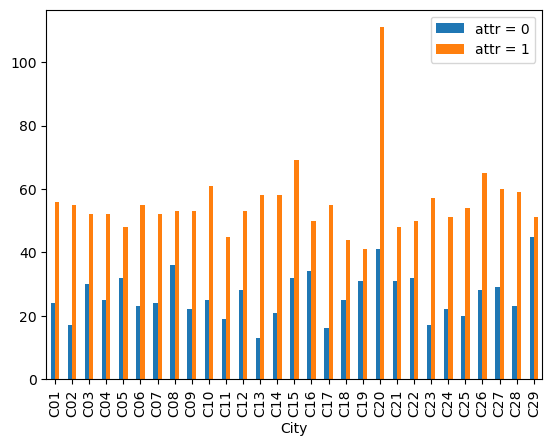

In [4]:
attrition_0 = desc_dataset.groupby('City')['Attrition'].apply(lambda x: (x==0).sum()).reset_index(name='attr = 0')
attrition_1 = desc_dataset.groupby('City')['Attrition'].apply(lambda x: (x==1).sum()).reset_index(name='attr_1')

combined = attrition_0.copy()
combined["attr = 1"] = attrition_1.attr_1

combined = combined.set_index(pd.Index(combined.City))

combined.plot(kind="bar")

tikzplotlib.save(FIG_PATH.joinpath("group_by_city.tex"))

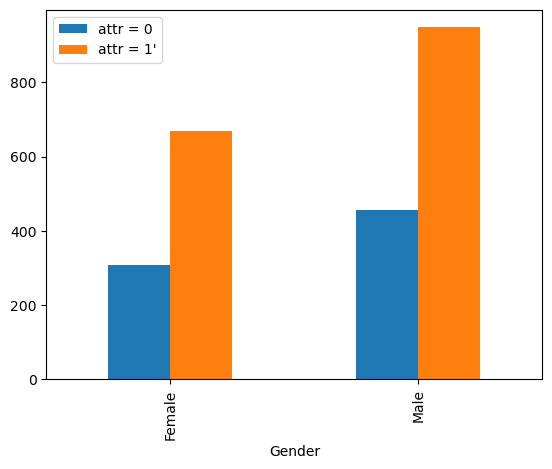

In [5]:
attrition_0 = desc_dataset.groupby('Gender')['Attrition'].apply(lambda x: (x==0).sum()).reset_index(name='attr = 0')
attrition_1 = desc_dataset.groupby('Gender')['Attrition'].apply(lambda x: (x==1).sum()).reset_index(name='attr = 1')

combined = attrition_0.copy()
combined["attr = 1'"] = attrition_1['attr = 1']

combined = combined.set_index(pd.Index(combined.Gender))

combined.plot(kind="bar")

tikzplotlib.save(FIG_PATH.joinpath("group_by_gender.tex"))

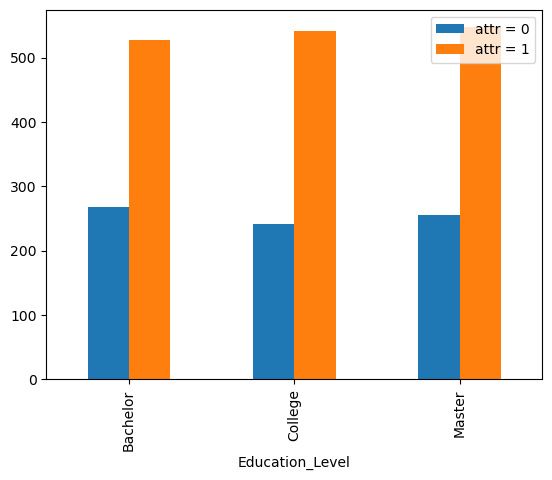

In [6]:
attrition_0 = desc_dataset.groupby('Education_Level')['Attrition'].apply(lambda x: (x==0).sum()).reset_index(name='attr = 0')
attrition_1 = desc_dataset.groupby('Education_Level')['Attrition'].apply(lambda x: (x==1).sum()).reset_index(name='attr = 1')

combined = attrition_0.copy()
combined["attr = 1"] = attrition_1["attr = 1"]

combined = combined.set_index(pd.Index(combined.Education_Level))

combined.plot(kind="bar")

tikzplotlib.save(FIG_PATH.joinpath("group_by_gender.tex"))

# Prototyping some classifications

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
X = dataset.drop(columns = ["Date", 
                            "Attrition", 
                            "Emp_ID", 
                            "Date_Of_Joining", 
                            "Last_Working_Date", 
                            "Joining_Designation", 
                            "Designation",
                            "Total_Business_Value",
                            # "Work_Duration",
                            # "Salary"
                            ]
                            )
y = dataset["Attrition"]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.2, random_state = 4259)

In [10]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

classifier = SVC()
train_test_model(classifier, X_train, y_train, X_test, y_test)

0.6813417190775681
              precision    recall  f1-score   support

           0       1.00      0.01      0.01       153
           1       0.68      1.00      0.81       324

    accuracy                           0.68       477
   macro avg       0.84      0.50      0.41       477
weighted avg       0.78      0.68      0.55       477



SVC()

In [11]:
'''
# Start with an initial guess for parameters
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['sigmoid', 'rbf']} 
# Which values are best?
# n_jobs=-1 will utilize all available CPUs
gridSearch = GridSearchCV(SVC(), param_grid, cv=5,  refit = True, verbose = 0)
gridSearch.fit(X_train, y_train)
print('Initial score: ', gridSearch.best_score_)
print('Initial parameters: ', gridSearch.best_params_)
'''

"\n# Start with an initial guess for parameters\nparam_grid = {'C': [0.1, 1, 10, 100, 1000], \n              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],\n              'kernel': ['sigmoid', 'rbf']} \n# Which values are best?\n# n_jobs=-1 will utilize all available CPUs\ngridSearch = GridSearchCV(SVC(), param_grid, cv=5,  refit = True, verbose = 0)\ngridSearch.fit(X_train, y_train)\nprint('Initial score: ', gridSearch.best_score_)\nprint('Initial parameters: ', gridSearch.best_params_)\n"

## Using a Decision Tree

In [13]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier()

model = train_test_model(dtc, X_train, y_train, X_test, y_test)

0.7274633123689728
              precision    recall  f1-score   support

           0       0.57      0.60      0.59       153
           1       0.81      0.79      0.80       324

    accuracy                           0.73       477
   macro avg       0.69      0.69      0.69       477
weighted avg       0.73      0.73      0.73       477



In [36]:
from sklearn.model_selection import GridSearchCV

# Start with an initial guess for parameters
param_grid = {
'max_depth': [10, 20, 30, 40],
'min_samples_split': [20, 40, 60, 80, 100],
'min_impurity_decrease': [0, 0.0005, 0.001, 0.005, 0.01],
'criterion': ["gini", "entropy"]
}
# Which values are best?
# n_jobs=-1 will utilize all available CPUs
gridSearch = GridSearchCV(DecisionTreeClassifier(random_state=1), param_grid, cv=5, n_jobs=-1)
gridSearch.fit(X_train, y_train)
print('Initial score: ', gridSearch.best_score_)
print('Initial parameters: ', gridSearch.best_params_)

Initial score:  0.7956913938389281
Initial parameters:  {'criterion': 'entropy', 'max_depth': 10, 'min_impurity_decrease': 0.01, 'min_samples_split': 20}


In [34]:
# Adapt grid based on result from initial grid search
param_grid = {
'max_depth': list(range(2, 16)), # 14 values
# 'min_samples_split': list(range(10, 30)), # 11 values
'min_samples_leaf': list(range(70, 100)),
'min_impurity_decrease': [0.001, 0.002, 0.003, 0.004], # 3 values
'criterion': ["entropy"]
}
gridSearch = GridSearchCV(DecisionTreeClassifier(random_state=1), param_grid, cv=5, n_jobs=-1)
gridSearch.fit(X_train, y_train)
print('Improved score: ', gridSearch.best_score_)
print('Improved parameters: ', gridSearch.best_params_)
bestClassTree = gridSearch.best_estimator_

Improved score:  0.7977980384030944
Improved parameters:  {'criterion': 'entropy', 'max_depth': 2, 'min_impurity_decrease': 0.001, 'min_samples_leaf': 90}


In [32]:
dtc = DecisionTreeClassifier(criterion="entropy", max_depth=8, min_impurity_decrease=0.002, min_samples_leaf=70)

model = train_test_model(dtc, X_train, y_train, X_test, y_test)

0.8029350104821803
              precision    recall  f1-score   support

           0       0.70      0.67      0.69       153
           1       0.85      0.86      0.86       324

    accuracy                           0.80       477
   macro avg       0.77      0.77      0.77       477
weighted avg       0.80      0.80      0.80       477



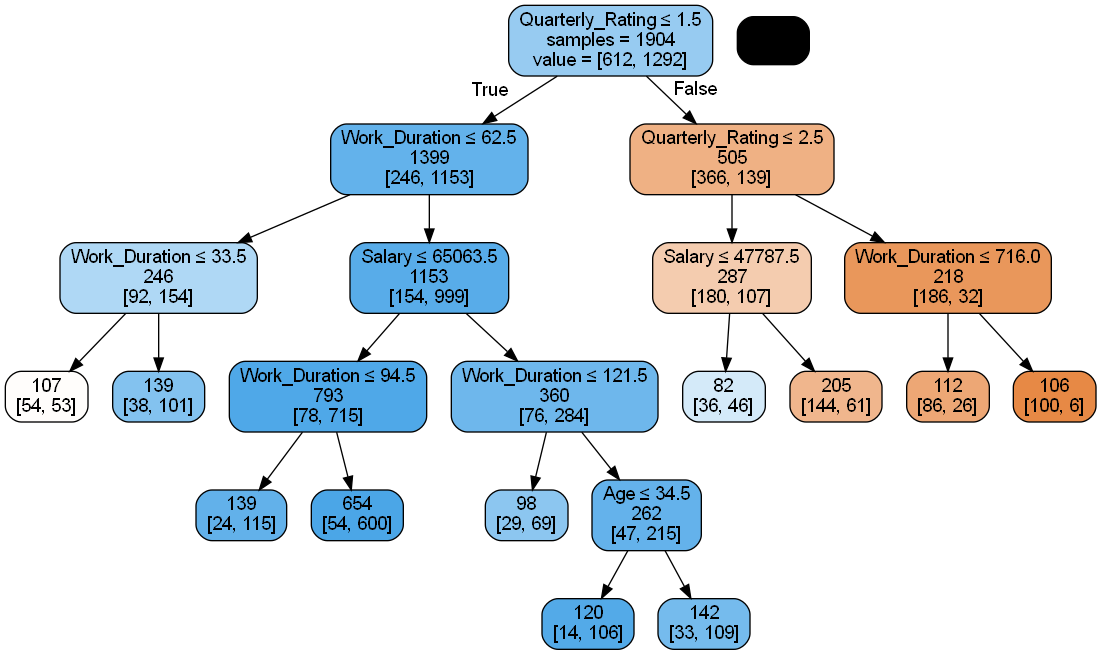

In [36]:
plotDecisionTree(model, feature_names = X_train.columns, pdfFile = FIG_PATH.joinpath("tree.pdf"))